<a href="https://colab.research.google.com/github/vinodgaitonde/ProjIdeas/blob/main/WordPredict_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Required packages

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import RMSprop
import numpy as np
import random
import sys

Load Text

In [2]:
filename = "./sample_data/junglebook.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()
print('corpus length:', len(raw_text))
print(raw_text[0:100])

FileNotFoundError: [Errno 2] No such file or directory: './sample_data/junglebook.txt'

# Data Preparation - Clean text

In [5]:
raw_text = ''.join(c for c in raw_text if not c.isdigit())

In [6]:
#How many total characters do we have in our training text?
chars = sorted(list(set(raw_text))) #List of every character
print('total chars:', len(chars))

total chars: 57


In [7]:
#Character sequences must be encoded as integers.
#Each unique character will be assigned an integer value.
#Create a dictionary of characters mapped to integer values
char_to_int = dict((c, i) for i, c in enumerate(chars))

In [8]:
#Do the reverse so we can print our predictions in characters and not integers
int_to_char = dict((i, c) for i, c in enumerate(chars))

Summarize the data

In [9]:
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters in the text; corpus length: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters in the text; corpus length:  305014
Total Vocab:  57


Create Input/Output sequence for training

In [10]:
seq_length = 60  #Length of each input sequence
step = 10   #Instead of moving 1 letter at a time, try skipping a few.
sentences = []    # X values (Sentences)
next_chars = []   # Y values. The character that follows the sentence defined as X
for i in range(0, n_chars - seq_length, step):  #step=1 means each sentence is offset just by a single letter
    sentences.append(raw_text[i: i + seq_length])  #Sequence in
    next_chars.append(raw_text[i + seq_length])  #Sequence out
n_patterns = len(sentences)
print('Number of sequences:', n_patterns)

Number of sequences: 30496


In [11]:
x = np.zeros((len(sentences), seq_length, n_vocab), dtype=bool)
y = np.zeros((len(sentences), n_vocab), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_int[char]] = 1
    y[i, char_to_int[next_chars[i]]] = 1

print(x.shape)
print(y.shape)

print(y[0:10])

(30496, 60, 57)
(30496, 57)
[[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False  True
  False False False False False False False False False False False False
  False False False False False False False False False]
 [False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False  True False False False False False False False
  False False False False False False False False False]
 [False  True False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False 

#Basic model with one LSTM

In [16]:
model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, n_vocab)))
model.add(Dense(n_vocab, activation='softmax'))

optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ["accuracy"])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          95,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 57)                  │           7,353 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,585 (400.72 KB)

 Trainable params: 102,585 (400.72 KB)

 Non-trainable params: 0 (0.00 B)

# define the checkpoint

In [32]:
from keras.callbacks import ModelCheckpoint

filepath="saved_weights/saved_weights-{epoch:02d}-{loss:.4f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]

# Fit the model

In [28]:
history = model.fit(x, y,
          batch_size=128,
          epochs=50,
          validation_split=0.2,
          callbacks=callbacks_list)

model.save('my_saved_weights_book_50epochs.keras')

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.4514 - loss: 1.9005
Epoch 1: loss did not improve from 0.62879
191/191 ━━━━━━━━━━━━━━━━━━━━ 34s 178ms/step - accuracy: 0.4514 - loss: 1.9003 - val_accuracy: 0.4128 - val_loss: 2.0578
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.4864 - loss: 1.7486
Epoch 2: loss did not improve from 0.62879
191/191 ━━━━━━━━━━━━━━━━━━━━ 43s 190ms/step - accuracy: 0.4864 - loss: 1.7485 - val_accuracy: 0.4103 - val_loss: 2.0660


Plot

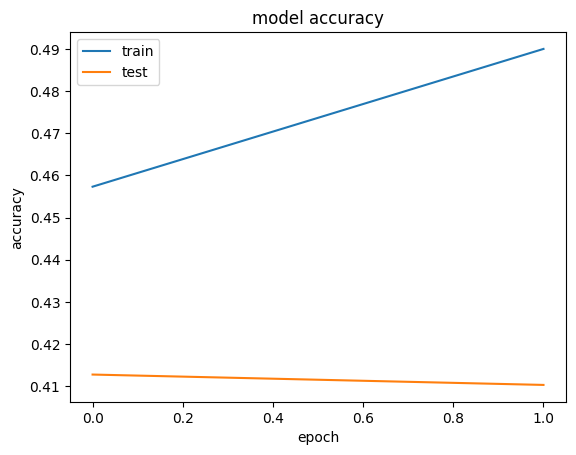

In [29]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

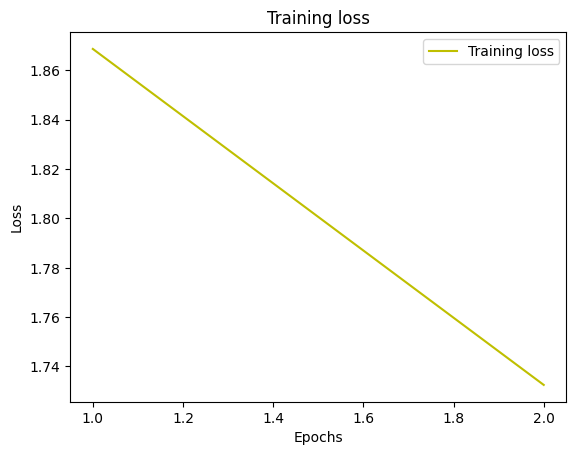

In [30]:
from matplotlib import pyplot as plt
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Generate Characters

In [31]:
def sample(preds):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds) #exp of log (x), isn't this same as x??
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Prediction

In [32]:
filename = "my_saved_weights_book_50epochs.keras"
model.load_weights(filename)

Pick a random sentence from the text as seed.

In [33]:
start_index = random.randint(0, n_chars - seq_length - 1)

Initiate generated text and keep adding new predictions and print them out

In [34]:
generated = ''
sentence = raw_text[start_index: start_index + seq_length]
generated += sentence

print('----- Seed for our text prediction: "' + sentence + '"')

----- Seed for our text prediction: "laces for river steamboats.
the body exhibited no traces of "


In [35]:
for i in range(400):   # Number of characters including spaces
    x_pred = np.zeros((1, seq_length, n_vocab))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_to_int[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds)
    next_char = int_to_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print()

previttel was deann the arring to yet was over the paper small
are their comeside, therle to his lignion. jaster posse, were used and have not
upon the tinked undeuily. his day.

“th?”

“in i unden the
iffuctous the to me were stepf be sucderence, and i and obser a throng. mise very serion at the arrimcice, it is your as cann of
out the steps, you. i seventimang the wnot
oneright
returnay. he has

